In [1]:
# Imports
import numpy as np

import random
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import mpl_toolkits.mplot3d.art3d as art3d

from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
import rl.policy
from rl.memory import SequentialMemory
import rl.callbacks
import json

ACTIONS = ["U", "U'", "D", "D'", "L", "L'", "R", "R'", "F", "F'", "B", "B'"]

In [2]:
# Cube class definition
class Cube:
    """
    Class represents a 2x2x2 Rubik's Cube.
    Written by Roei Aviad, 2022.
    """

    def __init__(self, new_cube: dict=None):
        if new_cube == None:
            self._cube = {}      # init solved cube
            self._cube['U'] = np.array([[0, 0], [0, 0]])
            self._cube['D'] = np.array([[1, 1], [1, 1]])
            self._cube['F'] = np.array([[2, 2], [2, 2]])
            self._cube['B'] = np.array([[3, 3], [3, 3]])
            self._cube['L'] = np.array([[4, 4], [4, 4]])
            self._cube['R'] = np.array([[5, 5], [5, 5]])
        else:
            self._cube = new_cube
        self._last_move = 'N'       # defualt (None)

    def move(self, action: str):
        self._last_move = action      # set last action
        # rotate clockwise:
        if action == "U":
            self._cube['F'][0], self._cube['R'][0], self._cube['B'][0], self._cube['L'][0] = self._cube['R'][0].copy(), self._cube['B'][0].copy(), self._cube['L'][0].copy(), self._cube['F'][0].copy()
        elif action == "D":
            self._cube['F'][1], self._cube['R'][1], self._cube['B'][1], self._cube['L'][1] = self._cube['L'][1].copy(), self._cube['F'][1].copy(), self._cube['R'][1].copy(), self._cube['B'][1].copy()
        elif action == "F":
            self._cube['U'][1], self._cube['R'][:, 0], self._cube['D'][0], self._cube['L'][:, 1] = self._cube['L'][:, 1][::-1].copy(), self._cube['U'][1].copy(), self._cube['R'][:, 0][::-1].copy(), self._cube['D'][0].copy()
        elif action == "L":
            self._cube['F'][:, 0], self._cube['D'][:, 0], self._cube['B'][:, 1], self._cube['U'][:, 0] = self._cube['U'][:, 0].copy(), self._cube['F'][:, 0].copy(), self._cube['D'][:, 0][::-1].copy(), self._cube['B'][:, 1][::-1].copy()
        elif action == "B":
            self._cube['U'][0], self._cube['L'][:, 0], self._cube['D'][1], self._cube['R'][:, 1] = self._cube['R'][:, 1].copy(), self._cube['U'][0][::-1].copy(), self._cube['L'][:, 0].copy(), self._cube['D'][1][::-1].copy()
        elif action == "R":
            self._cube['F'][:, 1], self._cube['U'][:, 1], self._cube['B'][:, 0], self._cube['D'][:, 1] = self._cube['D'][:, 1].copy(), self._cube['F'][:, 1].copy(), self._cube['U'][:, 1][::-1].copy(), self._cube['B'][:, 0][::-1].copy()

        # rotate counter clockwise:
        elif action == "U'":
            self._cube['R'][0], self._cube['B'][0], self._cube['L'][0], self._cube['F'][0] = self._cube['F'][0].copy(), self._cube['R'][0].copy(), self._cube['B'][0].copy(), self._cube['L'][0].copy()
        elif action == "D'":
            self._cube['R'][1], self._cube['B'][1], self._cube['L'][1], self._cube['F'][1] = self._cube['B'][1].copy(), self._cube['L'][1].copy(), self._cube['F'][1].copy(), self._cube['R'][1].copy()
        elif action == "F'":
            self._cube['R'][:, 0], self._cube['D'][0], self._cube['L'][:, 1], self._cube['U'][1] = self._cube['D'][0][::-1].copy(), self._cube['L'][:, 1].copy(), self._cube['U'][1][::-1].copy(), self._cube['R'][:, 0].copy()
        elif action == "L'":
            self._cube['D'][:, 0], self._cube['B'][:, 1], self._cube['U'][:, 0], self._cube['F'][:, 0] = self._cube['B'][:, 1][::-1].copy(), self._cube['U'][:, 0][::-1].copy(), self._cube['F'][:, 0].copy(), self._cube['D'][:, 0].copy()
        elif action == "B'":
            self._cube['L'][:, 0], self._cube['D'][1], self._cube['R'][:, 1], self._cube['U'][0] = self._cube['D'][1].copy(), self._cube['R'][:, 1][::-1].copy(), self._cube['U'][0].copy(), self._cube['L'][:, 0][::-1].copy()
        elif action == "R'":
            self._cube['U'][:, 1], self._cube['B'][:, 0], self._cube['D'][:, 1], self._cube['F'][:, 1] = self._cube['B'][:, 0][::-1].copy(), self._cube['D'][:, 1][::-1].copy(), self._cube['F'][:, 1].copy(), self._cube['U'][:, 1].copy()


        if "'" in action:
            self._cube[action[0]] = np.rot90(self._cube[action[0]])       # rotate backwords
        else:
            for _ in range(3):
                self._cube[action[0]] = np.rot90(self._cube[action[0]])   # rotate forwards

    def shuffle(self, length: int=14, verbose: bool=True) -> list:
        vprint = print if verbose else lambda *a, **k: None
        actions_map = ['U', 'D', 'L', 'R', 'F', 'B']        # define actions
        path = [self.copy()]

        vprint("Shuffle sequence: ", end=' ')

        i = 0
        while i < length:
            valid_actions = [actions_map[i] for i in range(len(actions_map)) if actions_map[i] != self._last_move[0]]     # remove last move
            action = valid_actions[random.randint(0, len(valid_actions) - 1)] + "'" * random.randint(0, 1)         # get random action

            times = 2 if random.randint(0, 10) == 0 else 1       # 1/11 chance to make move twice
            for _ in range(times):
                if i < length:
                    self.move(action)       # make a random action
                    path.insert(0, self.copy())
                    vprint(action, end=' ')
                    i += 1
        vprint("\n")

        return path        # return path

    def show(self):
        color_map = {2: 'red', 4: 'green', 5: 'blue', 1: 'yellow', 3: 'orange', 0: 'white'}
        
        temp_cube = {}      # copy cube and turn for visual effect
        temp_cube['U'] = np.rot90(self._cube['U'], k=3)
        temp_cube['D'] = np.flip(np.rot90(self._cube['D'], k=3), 1)
        temp_cube['F'] = np.rot90(self._cube['F'], k=3)
        temp_cube['B'] = np.flip(np.rot90(self._cube['B'], k=1), 1)
        temp_cube['L'] = np.flip(np.rot90(self._cube['L'], k=1), 1)
        temp_cube['R'] = np.rot90(self._cube['R'], k=3)

        axs = []
        fig = plt.figure()          # create 3d figure
        fig.set_size_inches(4, 2)
        for i in range(2):
            axs.append(fig.add_subplot(1, 2, i + 1, projection='3d'))
            axs[i].axis(False)
            axs[i].grid(False)

        special_order = ['L', 'R', 'F', 'B', 'D', 'U']      # for deciding on color and depth

        for side in range(len(special_order)):
            for i in range(2):
                for j in range(2):
                    r = Rectangle((i / 2, j / 2), 1 / 2, 1 / 2, ec='black', fc=color_map[temp_cube[special_order[side]][i][j]], alpha=(0.4 if side % 3 == 0 else 1))   # set correct color and location
                    axs[1 ^ (side & 1) ^ ((side & 2) >> 1)].add_patch(r)       # 034=1, 125=0
                    art3d.pathpatch_2d_to_3d(r, z=(side % 2), zdir=chr(ord('x') + (side // 2)))      # set correct plain based on side
        plt.show()

    def copy(self):
        temp_cube = {}
        for key in self._cube.keys():       # copy all inner arrays
            temp_cube[key] = self._cube[key].copy()
        return Cube(temp_cube)        # return duplicate
    
    def __eq__(self, other):
        for key in self._cube.keys():      # for every side
            if not (self._cube[key] == other._cube[key]).all():     # check equal
                return False
        return True

    def toarray(self) -> np.ndarray:
        return np.reshape(list(self._cube.values()), (24,))
    
    @property
    def cube(self):
        return self._cube


In [3]:
# RL environment definition
class CubeLearnEnv:
    """
    Rubik's cube 2x2x2 Deep Q-Learning environment class.
    Written by Roei Aviad, 2022.
    """
    
    def __init__(self, depth, verbose=False, default=None):
        self._depth = depth
        self._verbose = verbose
        self._default = default
        self.reset()        # init object

    def step(self, action: int) -> tuple:
        ACTIONS = ["U", "U'", "D", "D'", "L", "L'", "R", "R'", "F", "F'", "B", "B'"]
        self._cube.move(ACTIONS[action])         # rotate cube
        self._counter += 1
        if self._cube == Cube():
            self._reward = 100
            self._done = True
        elif self._counter % self._depth == 0:
            self._reward = -10
            self._cube = self._start_pos.copy()
        else:
            self._reward = -1
        return np.reshape(list(self._cube.copy().cube.values()), (24,)), self._reward, self._done, {}

    def reset(self) -> np.ndarray:
        self._cube = Cube(new_cube=self._default)        # create cube
        self._reward = 0           # init reward
        if self._default == None:
            self._path = self._cube.shuffle(self._depth, verbose=self._verbose)     # init correct path
        self._start_pos = self._cube.copy()
        self._counter = 0
        self._done = False         # set is done?
        return np.reshape(list(self._cube.copy().cube.values()), (24,))

    @property
    def cube(self):
        return self._cube.copy()

    @property
    def depth(self):
        return self._depth
    

In [4]:
# Create Keras model
model = Sequential()
model.add(Flatten(input_shape=(1, 24), name="flatten1"))
model.add(Dense(72, activation='relu', name="dense1"))
model.add(Dense(60, activation='relu', name="dense2"))
model.add(Dense(48, activation='relu', name="dense3"))
model.add(Dense(36, activation='relu', name="dense4"))
model.add(Dense(24, activation='relu', name="dense5"))
model.add(Dense(12, activation='linear', name="dense6"))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten1 (Flatten)          (None, 24)                0         
                                                                 
 dense1 (Dense)              (None, 72)                1800      
                                                                 
 dense2 (Dense)              (None, 60)                4380      
                                                                 
 dense3 (Dense)              (None, 48)                2928      
                                                                 
 dense4 (Dense)              (None, 36)                1764      
                                                                 
 dense5 (Dense)              (None, 24)                888       
                                                                 
 dense6 (Dense)              (None, 12)                3

In [5]:
# Create DQN agent
memory = SequentialMemory(limit=5000000, window_length=1)
policy = EpsGreedyQPolicy(eps=0.1)
nb_actions = 12
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=1000, \
    target_model_update=1e-2, policy=policy)
dqn.compile(Adam(learning_rate=1e-3), metrics=['accuracy'])

if os.path.exists("weights_v2.h5"):
    dqn.load_weights("weights_v2.h5")

In [6]:
# Train agent
depth = 3
for i in range(1, depth + 1):
    env = CubeLearnEnv(i)
    steps = 10000 * (i ** 2)
    history = dqn.fit(env, nb_steps=steps, visualize=False, verbose=2, nb_max_episode_steps=i ** 2 * 20)
    
    with open("history{0}.json".format(i), "w") as h_file:
        rewards = history.history["episode_reward"]
        n = 10
        rewards = [(sum(rewards[i:i+n]) / n) for i in range(0, len(rewards), n)]
        json.dump(rewards, h_file)
    
    if dqn.step < steps:
        break

Training for 10000 steps ...
    1/10000: episode: 1, duration: 0.127s, episode steps:   1, steps per second:   8, episode reward: 100.000, mean reward: 100.000 [100.000, 100.000], mean action: 4.000 [4.000, 4.000],  loss: --, accuracy: --, mean_q: --
    2/10000: episode: 2, duration: 0.002s, episode steps:   1, steps per second: 526, episode reward: 100.000, mean reward: 100.000 [100.000, 100.000], mean action: 4.000 [4.000, 4.000],  loss: --, accuracy: --, mean_q: --
    3/10000: episode: 3, duration: 0.002s, episode steps:   1, steps per second: 535, episode reward: 100.000, mean reward: 100.000 [100.000, 100.000], mean action: 6.000 [6.000, 6.000],  loss: --, accuracy: --, mean_q: --
    4/10000: episode: 4, duration: 0.003s, episode steps:   1, steps per second: 352, episode reward: 100.000, mean reward: 100.000 [100.000, 100.000], mean action: 6.000 [6.000, 6.000],  loss: --, accuracy: --, mean_q: --
    5/10000: episode: 5, duration: 0.003s, episode steps:   1, steps per second

c:\Users\משתמש\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   32/10000: episode: 29, duration: 0.003s, episode steps:   1, steps per second: 384, episode reward: 100.000, mean reward: 100.000 [100.000, 100.000], mean action: 10.000 [10.000, 10.000],  loss: --, accuracy: --, mean_q: --
   33/10000: episode: 30, duration: 0.002s, episode steps:   1, steps per second: 449, episode reward: 100.000, mean reward: 100.000 [100.000, 100.000], mean action: 9.000 [9.000, 9.000],  loss: --, accuracy: --, mean_q: --
   34/10000: episode: 31, duration: 0.002s, episode steps:   1, steps per second: 508, episode reward: 100.000, mean reward: 100.000 [100.000, 100.000], mean action: 3.000 [3.000, 3.000],  loss: --, accuracy: --, mean_q: --
   35/10000: episode: 32, duration: 0.002s, episode steps:   1, steps per second: 454, episode reward: 100.000, mean reward: 100.000 [100.000, 100.000], mean action: 0.000 [0.000, 0.000],  loss: --, accuracy: --, mean_q: --
   37/10000: episode: 33, duration: 0.003s, episode steps:   2, steps per second: 704, episode reward

c:\Users\משתמש\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


 1001/10000: episode: 911, duration: 1.153s, episode steps:   1, steps per second:   1, episode reward: 100.000, mean reward: 100.000 [100.000, 100.000], mean action: 8.000 [8.000, 8.000],  loss: --, accuracy: --, mean_q: --
 1002/10000: episode: 912, duration: 0.014s, episode steps:   1, steps per second:  70, episode reward: 100.000, mean reward: 100.000 [100.000, 100.000], mean action: 0.000 [0.000, 0.000],  loss: 195.889999, accuracy: 0.843750, mean_q: 113.232330
 1003/10000: episode: 913, duration: 0.014s, episode steps:   1, steps per second:  70, episode reward: 100.000, mean reward: 100.000 [100.000, 100.000], mean action: 8.000 [8.000, 8.000],  loss: 70.562363, accuracy: 0.906250, mean_q: 106.747871
 1004/10000: episode: 914, duration: 0.012s, episode steps:   1, steps per second:  81, episode reward: 100.000, mean reward: 100.000 [100.000, 100.000], mean action: 11.000 [11.000, 11.000],  loss: 8.325943, accuracy: 1.000000, mean_q: 103.206612
 1006/10000: episode: 915, duratio

In [20]:
# Save model
dqn.save_weights("weights_v2.h5", overwrite=True)

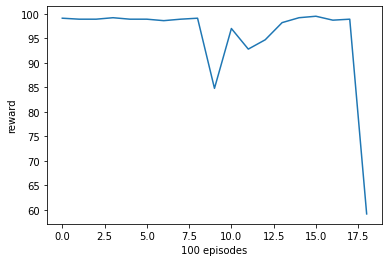

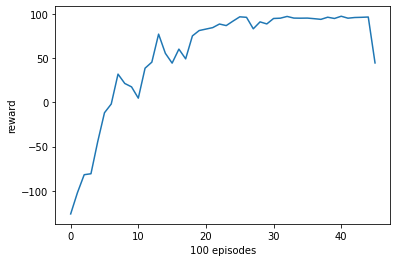

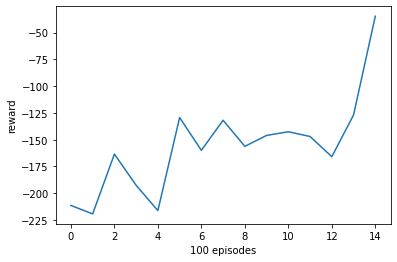

In [10]:
# Print reward graph
for i in range(1, depth + 1):
    with open("history{0}.json".format(i), "r") as h_file:
        rewards = json.load(h_file)
        n = 10
        rewards = [(sum(rewards[i:i+n]) / n) for i in range(0, len(rewards), n)]
        plt.plot(np.arange(0., float(len(rewards)), 1.), rewards)
        plt.xlabel("100 episodes")
        plt.ylabel("reward")
        plt.show()

In [11]:
# Accuracy
for i in range(1, depth + 2):
    test_env = CubeLearnEnv(i)
    n = 1000
    history = dqn.test(test_env, nb_episodes=n, visualize=False, verbose=0, nb_max_episode_steps=depth * 10)
    rewards = history.history["episode_reward"]
    accuracy = [(reward > 0) for reward in rewards].count(True) * (100 / n)
    mse = np.array(rewards)
    print(i, "turns:")
    print("mae: %.2f" % mean_absolute_error(mse, np.full(mse.size, 100)))
    print("accuracy: %.2f" % accuracy)

1 turns:
mae: 0.00
accuracy: 100.00
2 turns:
mae: 24.23
accuracy: 91.20
3 turns:
mae: 122.08
accuracy: 44.90
4 turns:
mae: 158.13
accuracy: 18.30


Testing for 1 episodes ...
Episode 1: reward: 98.000, steps: 3


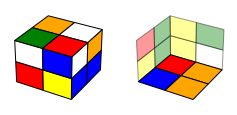

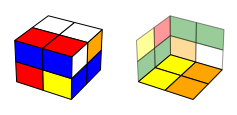

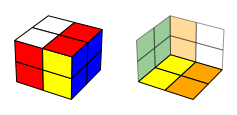

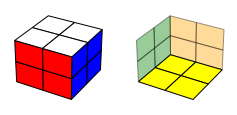

In [7]:
# Show results
class EpisodeLogger(rl.callbacks.Callback):
    def __init__(self, env):
        self._env = env
        self._success = False
        self._path = []

    def on_step_begin(self, episode, logs):
        if self._env.cube not in self._path:
            self._path.append(self._env.cube.copy())
        
    def on_step_end(self, step, logs):
        self._path.append(self._env.cube.copy())
        self._success = logs['reward'] == 100

    def view(self):
        if self._success:
            for cube in self._path[-(self._env.depth + 1):]:
                cube.show()
        else:
            print("Failed to solve the cube :(")


cube = Cube()
path = input("Enter shuffle sequence: ")        # for example: F L R
for action in path.split(" "):
    cube.move(action)

test_env = CubeLearnEnv(depth, default=cube.cube)
logger = EpisodeLogger(test_env)
dqn.test(test_env, nb_episodes=1, visualize=False, callbacks=[logger], nb_max_episode_steps=depth * 10)
logger.view()